In [1]:
"""
Bayesian PsuedoCount updating
"""

from RangeAgent import EvalAgentDeepRange
from TreeAgent import EvalAgentTree
from ucb import MAB

from PokerRL.game.games import StandardLeduc  # or any other game
from PokerRL.eval.rl_br.RLBRArgs import RLBRArgs

from DeepCFR.EvalAgentDeepCFR import EvalAgentDeepCFR
from DeepCFR.TrainingProfile import TrainingProfile
from DeepCFR.workers.driver.Driver import Driver

rlbr_args = RLBRArgs(
    rlbr_bet_set = None
)

t_prof = TrainingProfile(
    name="DEEPCOPY_v0",
    nn_type="feedforward",
    
    max_buffer_size_adv=3e6,
    eval_agent_export_freq=20,  # export API to play against the agent
    n_traversals_per_iter=1500,
    n_batches_adv_training=750,
    n_batches_avrg_training=2000,
    n_merge_and_table_layer_units_adv=64,
    n_merge_and_table_layer_units_avrg=64,
    n_units_final_adv=64,
    n_units_final_avrg=64,
    mini_batch_size_adv=2048,
    mini_batch_size_avrg=2048,
    init_adv_model="last",
    init_avrg_model="last",
    use_pre_layers_adv=False,
    use_pre_layers_avrg=False,

    game_cls=StandardLeduc,

    # You can specify one or both modes. Choosing both is useful to compare them.
    eval_modes_of_algo=(
     # EvalAgentDeepCFR.EVAL_MODE_SINGLE,  # SD-CFR
     EvalAgentDeepCFR.EVAL_MODE_AVRG_NET,  # Deep-CFR
    ),

    DISTRIBUTED=False,
    rl_br_args=rlbr_args
)


 ************************** Initing args for:  DEEPCOPY_v0   **************************


In [2]:
import numpy as np
import torch
import torch.nn as nn

import time
from copy import deepcopy

action_loss = nn.CrossEntropyLoss()

def hole_card_onehot(hole_card):
    rank = hole_card[0][0]
    suit = hole_card[0][1]
    out = rank + suit * 3 ## arbitrary but it will learn the relationship
    return torch.LongTensor([out])

def best_response(agent):
    """
    Returns strategy that is best response to agent strategy
    """
    br = EvalAgentTree(t_prof, br_agent=agent, mode=None, device=None)
    br.mode = "BR"
    return br

def train_while_play(student_agent, enemy_agent, args={'lr':1e-2, 'iters':10000}):
    """
    Train student_agent to play against stationery enemy_agent.
    """
            
    env_bldr = student_agent.env_bldr
    env_cls = env_bldr.env_cls
    env_args = env_bldr.env_args
    lut_holder = env_cls.get_lut_holder()
    
    assert(student_agent.env_bldr.env_cls == enemy_agent.env_bldr.env_cls)
    assert(env_args.n_seats == 2)

    optimizer = torch.optim.Adam(list(student_agent.policy[0]._net.parameters()) + \
                                 list(student_agent.policy[1]._net.parameters()), lr=args['lr'])
    start_time = time.time()
    
    REFERENCE_AGENT = 0
    
    _env = env_cls(env_args=env_args, lut_holder=lut_holder, is_evaluating=True)
    _eval_agents = [enemy_agent, deepcopy(student_agent)] # play against an new frozen copy of the BR to agent while training
    
    results = {
        "action_loss": [],
        "winnings": []
    }
    iters = 0 # number of hands played
    evals = 0 # number of teaching moments
    
    # zero grads, set net to train mode
    student_agent.policy[0]._net.train()
    student_agent.policy[1]._net.train()
    optimizer.zero_grad()

    while iters < args['iters']:
        iters += 1
        
        if iters % 100 == 0:
            print("Iters {} | Evals {} | ActionLoss {} | Winnings mBB/Hand {} | ".format(
                iters, evals, sum(results['action_loss']) / evals, sum(results["winnings"]) / iters
            ))
            
            optimizer.step()
            optimizer.zero_grad()
            
            ## _eval_agents[0] = deepcopy(student_agent)
            
            # play against an new frozen copy of the BR to agent while training
            _eval_agents[1] = best_response(deepcopy(student_agent)) 
        
        for seat_p0 in range(_env.N_SEATS):
            seat_p1 = 1 - seat_p0
            
            # """""""""""""""""
            # Reset Episode
            # """""""""""""""""
            _, r_for_all, done, info = _env.reset()
            for e in _eval_agents:
                e.reset(deck_state_dict=_env.cards_state_dict())

            # """""""""""""""""
            # Play Episode
            # """""""""""""""""

            while not done:
                p_id_acting = _env.current_player.seat_id

                if p_id_acting == seat_p0:
                    evals += 1 #increment counter
                    
                    # set student to position of agent 1, estimate range + actions
                    student_agent.set_env_wrapper(_eval_agents[REFERENCE_AGENT]._internal_env_wrapper) 
                    student_a_probs = student_agent.get_a_probs_tensor()
                    
                    # get true values 
                    action_int, _ = _eval_agents[REFERENCE_AGENT].get_action(step_env=True, need_probs=False)
                    
                    # print("True:", a_probs, range_label)
                    # print("Prediction:", student_a_probs, student_range_probs)
                    # print("Checking requires_grad:", student_a_probs.requires_grad, student_range_probs.requires_grad)
                    
                    # compute loss
                    loss = action_loss(student_a_probs.view(1,-1), torch.LongTensor([action_int]))
                    results['action_loss'].append(loss)
                    
                    # print("Loss:", rloss, aloss, loss)
                    
                    # backpropogate
                    loss.backward() # accumulate gradients over many steps
                                        
                    # notify opponent
                    _eval_agents[1 - REFERENCE_AGENT].notify_of_action(p_id_acted=p_id_acting,
                                                                       action_he_did=action_int)
                elif p_id_acting == seat_p1:
                    action_int, _ = _eval_agents[1 - REFERENCE_AGENT].get_action(step_env=True,
                                                                                 need_probs=False)
                    _eval_agents[REFERENCE_AGENT].notify_of_action(p_id_acted=p_id_acting,
                                                                   action_he_did=action_int)
                else:
                    raise ValueError("Only HU supported!")

                _, r_for_all, done, info = _env.step(action_int)
                
            # """""""""""""""""
            # Add Rews
            # """""""""""""""""
            results["winnings"].append(r_for_all[seat_p0] * _env.REWARD_SCALAR * _env.EV_NORMALIZER)
    
    end_time = time.time()
    print("Time taken", end_time - start_time)

    print(optimizer)
    
    return results

In [3]:
import numpy as np
import torch
import torch.nn as nn

import time
from copy import deepcopy

action_loss = nn.CrossEntropyLoss()

def best_response(agent):
    """
    Returns strategy that is best response to agent strategy
    """
    br = EvalAgentTree(t_prof, br_agent=agent, mode=None, device=None)
    br.mode = "BR"
    return br

def bayesian_while_play(bayesian_agent, enemy_agent, args={'lr':1e-2, 'iters':10000}):
    """
    Train bayesian_agent to mimic stationery enemy_agent.
    """
            
    env_bldr = bayesian_agent.env_bldr
    env_cls = env_bldr.env_cls
    env_args = env_bldr.env_args
    lut_holder = env_cls.get_lut_holder()
    
    assert(bayesian_agent.env_bldr.env_cls == enemy_agent.env_bldr.env_cls)
    assert(env_args.n_seats == 2)

    start_time = time.time()
    
    REFERENCE_AGENT = 0
    
    _env = env_cls(env_args=env_args, lut_holder=lut_holder, is_evaluating=True)
    _eval_agents = [enemy_agent, deepcopy(bayesian_agent)] # play against an new frozen copy of the BR to agent while training
    
    results = {
        "winnings": []
    }
    iters = 0 # number of hands played
    evals = 0 # number of teaching moments

    while iters < args['iters']:
        iters += 1
        
        if iters % 100 == 0:
            print("Iters {} | Evals {} | Winnings mBB/Hand {} | ".format(
                iters, evals, sum(results["winnings"]) / iters
            ))
            
            # play against an new frozen copy of the BR to agent while training
            _eval_agents[1] = best_response(deepcopy(bayesian_agent)) 
        
        for seat_p0 in range(_env.N_SEATS):
            seat_p1 = 1 - seat_p0
            
            # """""""""""""""""
            # Reset Episode
            # """""""""""""""""
            _, r_for_all, done, info = _env.reset()
            for e in _eval_agents:
                e.reset(deck_state_dict=_env.cards_state_dict())

            # """""""""""""""""
            # Play Episode
            # """""""""""""""""

            while not done:
                p_id_acting = _env.current_player.seat_id

                if p_id_acting == seat_p0:
                    evals += 1 #increment counter
                    
                    # set bayesian agent to position of agent 1, update psuedocount
                    bayesian_agent.set_env_wrapper(_eval_agents[REFERENCE_AGENT]._internal_env_wrapper)
                    node = bayesian_agent._find_node_by_env(bayesian_agent._internal_env_wrapper._action_history_list)
                    range_idx = bayesian_agent._internal_env_wrapper.env.get_range_idx(p_id=p_id_acting) #get opponent hole card
                    
                    # get true values 
                    action_int, _ = _eval_agents[REFERENCE_AGENT].get_action(step_env=True, need_probs=False)
                    
                    # update pseudocount
                    node.data[range_idx, action_int] += 1 #node.allowed_actions.index(action_int)
                    
                    # notify opponent
                    _eval_agents[1 - REFERENCE_AGENT].notify_of_action(p_id_acted=p_id_acting,
                                                                       action_he_did=action_int)
                    
                elif p_id_acting == seat_p1:
                    action_int, _ = _eval_agents[1 - REFERENCE_AGENT].get_action(step_env=True,
                                                                                 need_probs=False)
                    _eval_agents[REFERENCE_AGENT].notify_of_action(p_id_acted=p_id_acting,
                                                                   action_he_did=action_int)
                else:
                    raise ValueError("Only HU supported!")

                _, r_for_all, done, info = _env.step(action_int)
                
            # """""""""""""""""
            # Add Rews
            # """""""""""""""""
            results["winnings"].append(r_for_all[seat_p0] * _env.REWARD_SCALAR * _env.EV_NORMALIZER)
    
    end_time = time.time()
    print("Time taken", end_time - start_time)
    
    return results

In [4]:

agent_file1 = "/home/leduc/poker_ai_data/eval_agent/SD-CFR_LEDUC_EXAMPLE_200/120/eval_agentAVRG_NET.pkl"
agent_file2 = "/home/leduc/poker_ai_data/eval_agent/SD-CFR_LEDUC_EXAMPLE_200/20/eval_agentAVRG_NET.pkl"
agent_file3 = "/home/leduc/poker_ai_data/eval_agent/SD-CFR_LEDUC_EXAMPLE_2/2/eval_agentAVRG_NET.pkl"

nash_agent = EvalAgentDeepCFR.load_from_disk(path_to_eval_agent=agent_file1)

def get_random_agent():
    random_agent = EvalAgentTree(t_prof, br_agent=nash_agent, mode=None, device=None)
    random_agent.tree.fill_uniform_random()
    random_agent.mode = "EVAL"
    return random_agent

In [54]:
#### ONLY RUN THIS ONCE, THEN CALL FROM HERE 


## To exploit
strong_agent = EvalAgentDeepCFR.load_from_disk(path_to_eval_agent=agent_file2)
weak_agent = EvalAgentDeepCFR.load_from_disk(path_to_eval_agent=agent_file3)
random_agent = get_random_agent()

exploited_agents = [('strong_agent', strong_agent), ('weak_agent', weak_agent), ('random_agent', random_agent)]

## To test with
bayesian_agent = EvalAgentTree(t_prof, br_agent=nash_agent, mode="BAYESIAN", device=None)

mab_agents = [get_random_agent() for i in range(22)] + [strong_agent, weak_agent, nash_agent]

student_agent = EvalAgentDeepRange(t_prof, mode=None, device=None)
student_agent.policy[0]._net.load_state_dict(nash_agent.avrg_net_policies[0]._net.state_dict())
student_agent.policy[1]._net.load_state_dict(nash_agent.avrg_net_policies[1]._net.state_dict())

test_agents = [('student_agent', student_agent), ('bayesian_agent', bayesian_agent), ('mab_agent', mab_agents)]

In [56]:
enemy_agent = weak_agent
iters = 5000

bayesian_results = bayesian_while_play(bayesian_agent, enemy_agent, args={'lr':1e-2, 'iters':iters})
student_results = train_while_play(student_agent, enemy_agent, args={'lr':2e-2, 'iters':iters})
bandit = MAB(mab_agents, enemy_agent, gamma = 0.5, n_hands = 10)
bandit.run(n_episodes=int(iters/10))

Iters 100 | Evals 399 | Winnings mBB/Hand -620.0 | 
Iters 200 | Evals 908 | Winnings mBB/Hand -2470.0 | 
Iters 300 | Evals 1402 | Winnings mBB/Hand -2850.0 | 
Iters 400 | Evals 1897 | Winnings mBB/Hand -3527.5 | 
Iters 500 | Evals 2394 | Winnings mBB/Hand -3802.0 | 
Iters 600 | Evals 2892 | Winnings mBB/Hand -3928.3333333333335 | 
Iters 700 | Evals 3393 | Winnings mBB/Hand -4038.5714285714284 | 
Iters 800 | Evals 3882 | Winnings mBB/Hand -4081.25 | 
Iters 900 | Evals 4398 | Winnings mBB/Hand -4135.555555555556 | 
Iters 1000 | Evals 4920 | Winnings mBB/Hand -4167.0 | 
Iters 1100 | Evals 5427 | Winnings mBB/Hand -4121.818181818182 | 
Iters 1200 | Evals 5961 | Winnings mBB/Hand -4211.666666666667 | 
Iters 1300 | Evals 6482 | Winnings mBB/Hand -4164.615384615385 | 
Iters 1400 | Evals 6989 | Winnings mBB/Hand -4192.857142857143 | 
Iters 1500 | Evals 7490 | Winnings mBB/Hand -4231.333333333333 | 
Iters 1600 | Evals 8017 | Winnings mBB/Hand -4305.0 | 
Iters 1700 | Evals 8542 | Winnings mBB/Ha


Played 20 hands of poker.
Player  COPYCAT: 1950.0 +/- 1957.4257164509825
Player  AVRG_NET: -1950.0 +/- 1957.4257164509825
UCB List:  [-749.2588480963162, 500.7411519036838, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf]
best agent, reward, arm_times, avg reward 2 1950.0 1 1950.0

Played 20 hands of poker.
Player  AVRG_NET: 1200.0 +/- 2044.4219631848957
Player  AVRG_NET: -1200.0 +/- 2044.4219631848957

Played 20 hands of poker.
Player  COPYCAT: 700.0 +/- 1726.0244355654268
Player  AVRG_NET: -700.0 +/- 1726.0244355654268
UCB List:  [-749.1674453888423, 500.8325546111577, 1950.8325546111578, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf]
best agent, reward, arm_times, avg reward 3 700.0 1 700.0

Played 20 hands of poker.
Player  AVRG_NET: 900.0 +/- 1713.7395195865854
Player  AVRG_NET: -900.0 +/- 1713.7395195865854

Played 20 hands of poker.
Player  COPYCAT: 9

Played 20 hands of poker.
Player  AVRG_NET: -50.0 +/- 2275.0990724928006
Player  AVRG_NET: 50.0 +/- 2275.0990724928006

Played 20 hands of poker.
Player  COPYCAT: -150.0 +/- 1145.1750586790872
Player  AVRG_NET: 150.0 +/- 1145.1750586790872
UCB List:  [-748.7978411590193, 501.2021588409807, 1951.2021588409807, 701.2021588409807, 901.2021588409807, -98.79784115901928, 251.2021588409807, -948.7978411590193, 1601.2021588409807, 951.2021588409807, -1548.7978411590193, 101.20215884098072, 2051.2021588409807, -598.7978411590193, -298.7978411590193, -1498.7978411590193, 1401.2021588409807, inf, inf, inf, inf, inf, inf, inf, inf]
best agent, reward, arm_times, avg reward 17 -150.0 1 -150.0

Played 20 hands of poker.
Player  AVRG_NET: 750.0 +/- 2031.580329605801
Player  AVRG_NET: -750.0 +/- 2031.580329605801

Played 20 hands of poker.
Player  COPYCAT: 650.0 +/- 1961.3470285044307
Player  AVRG_NET: -650.0 +/- 1961.3470285044307
UCB List:  [-748.7866494778576, 501.2133505221424, 1951.2133505221425

AssertionError: 

Text(0.5, 1.0, 'Exploiting Weak Agent')

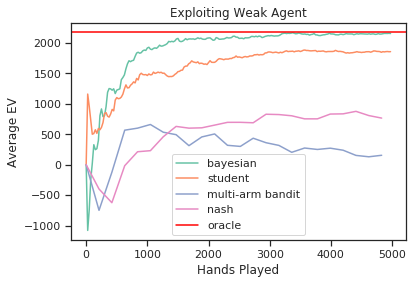

In [63]:
import seaborn as sns
sns.set(style='ticks', palette='Set2')
sns.despine()

from matplotlib import pyplot as plt
%matplotlib inline

plt.xlabel('Hands Played')
plt.ylabel('Average EV')
plt.plot(list(range(0,iters,25)), [0] + [-sum(bayesian_results['winnings'][:i])/i for i in range(25,iters,25)], label='bayesian')
plt.plot(list(range(0,iters,25)), [0] + [-sum(student_results['winnings'][:i])/i for i in range(25,iters,25)], label='student')
plt.plot(list(range(0,iters+10,210)), bandit.reward_list, label='multi-arm bandit')
plt.plot(list(range(0,iters+10,210)), [0] + bandit.nash, label='nash')
plt.axhline(y=2180, label='oracle', color='red')
plt.legend()
plt.title("Exploiting Weak Agent")

In [62]:
## Absolute Best Response

from H2HEvaluator import H2HEval

agent_file1 = "/home/leduc/poker_ai_data/eval_agent/SD-CFR_LEDUC_EXAMPLE_200/120/eval_agentAVRG_NET.pkl"

nash_agent = EvalAgentDeepCFR.load_from_disk(path_to_eval_agent=agent_file1)

def best_response(agent):
    """
    Returns strategy that is best response to agent strategy
    """
    br = EvalAgentTree(t_prof, br_agent=agent, mode=None, device=None)
    br.mode = "BR"
    return br

n_games = 5000

print("\nWeak agent vs Oracle")
H2HEval(enemy_agent, best_response(enemy_agent)).h2h_eval(n_games=n_games)

print("\nWeak agent vs Bayesian")
H2HEval(enemy_agent, best_response(bayesian_agent)).h2h_eval(n_games=n_games)

print("\nWeak agent vs Nash")
H2HEval(enemy_agent, nash_agent).h2h_eval(n_games=n_games)

print("\nWeak agent vs Student")
H2HEval(enemy_agent, best_response(student_agent)).h2h_eval(n_games=n_games)




Weak agent vs Oracle

Played 10000 hands of poker.
Player  AVRG_NET: -2179.0 +/- 106.80105078125
Player  BESTRESPONSE: 2179.0 +/- 106.80105078125

Weak agent vs Bayesian

Played 10000 hands of poker.
Player  AVRG_NET: -2225.0 +/- 105.12650449218751
Player  BESTRESPONSE: 2225.0 +/- 105.12650449218751

Weak agent vs Nash


KeyboardInterrupt: 

In [32]:
bandit.nash

[2150.0,
 2125.0,
 2050.0,
 1425.0,
 1590.0,
 1675.0,
 1485.7142857142858,
 1431.25,
 1427.7777777777778,
 1295.0,
 1031.8181818181818,
 1058.3333333333333,
 1011.5384615384615,
 971.4285714285714,
 863.3333333333334,
 731.25,
 741.1764705882352,
 755.5555555555555,
 721.0526315789474,
 717.5,
 654.7619047619048,
 702.2727272727273,
 693.4782608695652,
 679.1666666666666,
 712.0,
 678.8461538461538,
 688.8888888888889,
 703.5714285714286,
 675.8620689655172,
 720.0,
 743.5483870967741,
 745.3125,
 684.8484848484849,
 717.6470588235294,
 728.5714285714286,
 726.3888888888889,
 717.5675675675676,
 727.6315789473684,
 719.2307692307693,
 788.75,
 787.8048780487804,
 795.2380952380952,
 812.7906976744187,
 826.1363636363636,
 857.7777777777778,
 866.304347826087,
 854.2553191489362,
 867.7083333333334,
 875.5102040816327,
 903.0,
 905.8823529411765,
 881.7307692307693,
 883.0188679245283,
 885.1851851851852,
 879.0909090909091,
 889.2857142857143,
 887.719298245614,
 875.0,
 900.0,
 905.83